# Tutorial on how to rotate maps in healpy
categories: [healpy,cmb,cosmology]

In [1]:
import healpy as hp
import numpy as np
import os
import astropy.units as u
import matplotlib.pyplot as plt
hp.disable_warnings()
%matplotlib inline

In this notebook we will explore different ways of rotating maps in `healpy`.

## Create an input map

We simulate a simple galactic plane like horizontal band and a strong source at the galactic center.

In [2]:
nside = 128
m = np.zeros(hp.nside2npix(nside))

In [3]:
gal_width = 20 * u.deg

In [4]:
galaxy_plane_pixels = hp.query_strip(nside, np.pi/2 - gal_width.to_value(u.radian),
                                     np.pi/2+ gal_width.to_value(u.radian))

In [5]:
m[galaxy_plane_pixels] = 10

In [6]:
source_vector = hp.ang2vec(theta=np.pi/2, phi=0)

In [7]:
source_vector

array([1.000000e+00, 0.000000e+00, 6.123234e-17])

In [8]:
galactic_center_pixels = hp.query_disc(nside, source_vector, radius=(5*u.deg).to_value(u.radian))

In [9]:
m[galactic_center_pixels] = 50

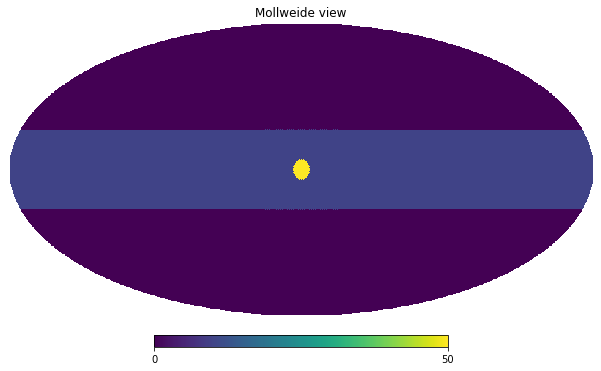

In [10]:
hp.mollview(m)

We do not want to have sharp steps in the map, therefore we smooth it with a 5 degrees beam:

In [11]:
m_smoothed = hp.smoothing(m, fwhm=(5*u.deg).to_value(u.radian))

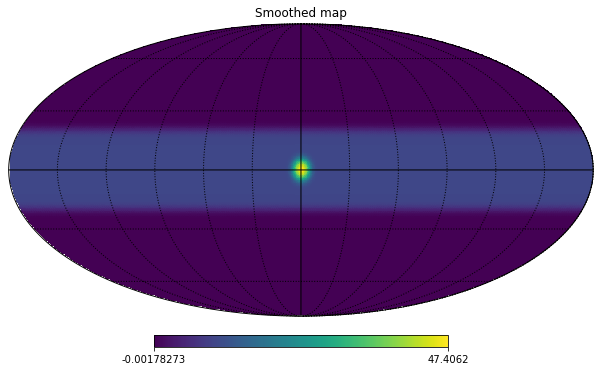

In [12]:
hp.mollview(m_smoothed, title="Smoothed map")
hp.graticule();

## Rotation in plotting

The most common reason for applying a rotation is when we want to change reference frame, `healpy` supports Galactic, Ecliptic and Equatorial.
If we just need it for plotting, we can use the `coord` keyword for all plotting functions, for example, "GC" converts the map from Galactic to Equatorial:

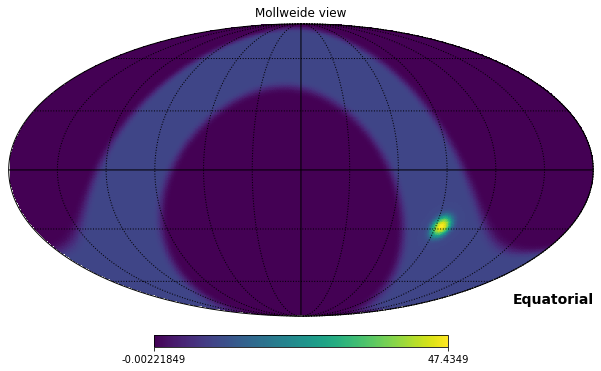

In [13]:
hp.mollview(m_smoothed, coord="GC")
hp.graticule();

Instead if we want to specify a custom rotation, we can use the `rot` keyword.
It accepts, longitute and latitude (in this order) in degrees, that point will be the center of the new reference frame.
So instead if we want to move the source at the galactic center to Longitude 10 and Latitude 20,
see the red dot below:

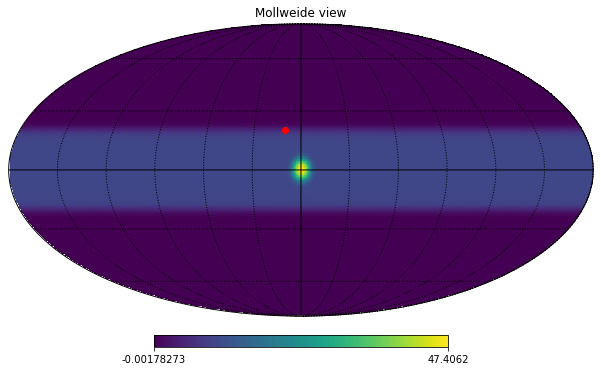

In [14]:
hp.mollview(m_smoothed)
hp.projplot(10,20, 'ro', lonlat=True)
hp.graticule();

We need to provide $-10 ^{\circ}, -20 ^{\circ}$ to `rot`:

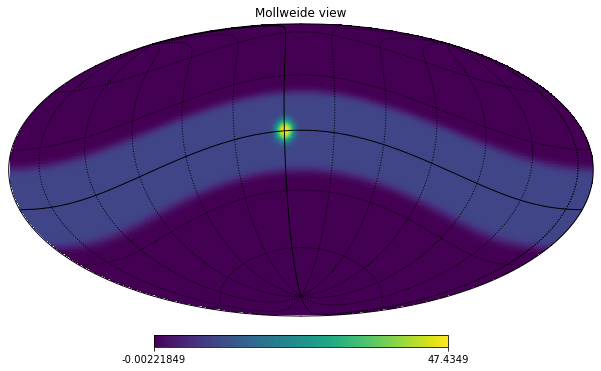

In [15]:
hp.mollview(m_smoothed, rot=[-10, -20])
hp.graticule();

We can also provide a third argument to `rot` to rotate the orientation of the galactic plane:

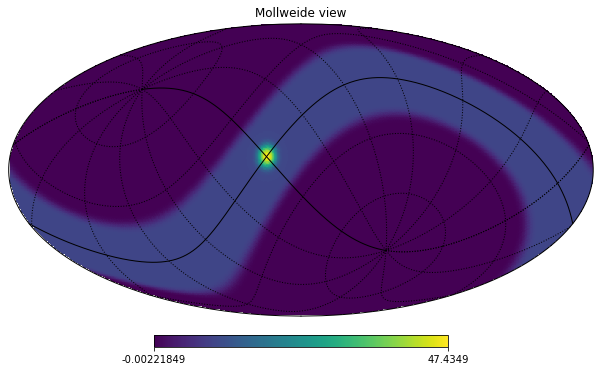

In [16]:
hp.mollview(m_smoothed, rot=[-10, -20, 45])
hp.graticule();

The same works for `gnomview`, we can center the map at the point specified by `rot`, then adjust the sky area with `xsize` and `reso`

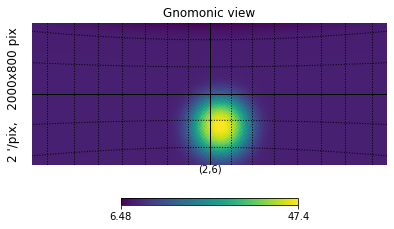

In [17]:
hp.gnomview(m_smoothed, rot=[2, 6], xsize=2000, ysize=800, reso=2)
hp.graticule();

## Rotate the actual array

Instead if we need to do further processing to the map and rotate the actual array, we need to use a Rotator,
it accepts the same argument we saw above:

In [18]:
rot_gal2eq = hp.Rotator(coord="GC")

Let's take as an example instead a custom rotator, let's say that we want to move the source at the galactic center to the coordinates $10 ^{\circ}, 20^{\circ}$.

The definition of rotation in `healpy` is that the point provided in `rot` will be the center of the map.

In [19]:
longitude = -10 * u.deg
latitude = -20 * u.deg
rot_custom = hp.Rotator(rot=[longitude.to_value(u.deg), latitude.to_value(u.deg)])

and this works fine as expected:

In [20]:
rot_custom(-10, -20, lonlat=True)

array([ 0.00000000e+00, -1.42108547e-14])

However, this causes a small error for the rotation of $(0^\circ,0^\circ)$:

In [21]:
rot_custom(0, 0, lonlat=True)

array([10.62758414, 19.68349808])

The correct way of defining this rotation is to use $(10^\circ,20^\circ)$ and then specify the `inv` keyword to use the inverse transform:

In [22]:
longitude = 10 * u.deg
latitude = 20 * u.deg
rot_custom = hp.Rotator(rot=[longitude.to_value(u.deg), latitude.to_value(u.deg)], inv=True)

It can also be used to rotate vectors:

In [23]:
rot_custom(0, 0, lonlat=True)

array([10., 20.])

Finally we can rotate the full map, there are 2 ways, either in spherical harmonics or pixel space.
It is generally better to do the rotation in spherical harmonics space, because rotating in pixel space does interpolation so has a smoothing effect on the map, anyway it could be used in particular cases for example when the map is not full-sky.

They are both methods of the `Rotator` object, get the input map and return the rotated map:

In [24]:
m_smoothed_rotated_alms = rot_custom.rotate_map_alms(m_smoothed)

In [25]:
m_smoothed_rotated_alms.max()

47.4755560735065

In [26]:
m_smoothed_rotated_pixel = rot_custom.rotate_map_pixel(m_smoothed)

In [27]:
m_smoothed_rotated_pixel.max()

47.38040671208857

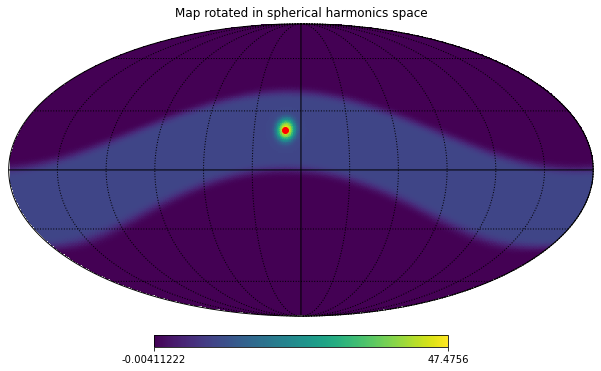

In [28]:
hp.mollview(m_smoothed_rotated_alms, title="Map rotated in spherical harmonics space")
hp.projplot(10,20, 'ro', lonlat=True)
hp.graticule();

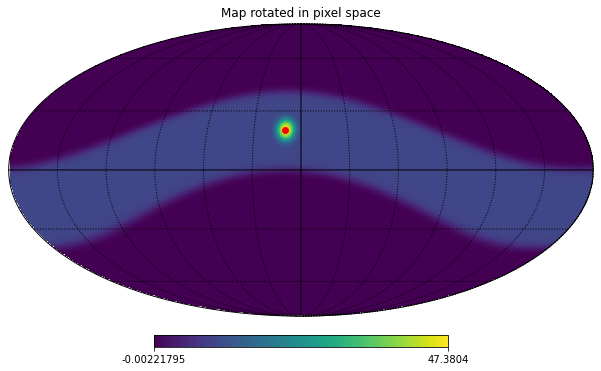

In [29]:
hp.mollview(m_smoothed_rotated_pixel, title="Map rotated in pixel space")
hp.projplot(10,20, 'ro', lonlat=True)
hp.graticule();

## Compare rotation in spherical harmonics and pixel space

If we compare the maps, there is significant difference,
we can rotate back and check the residuals with the two methods.

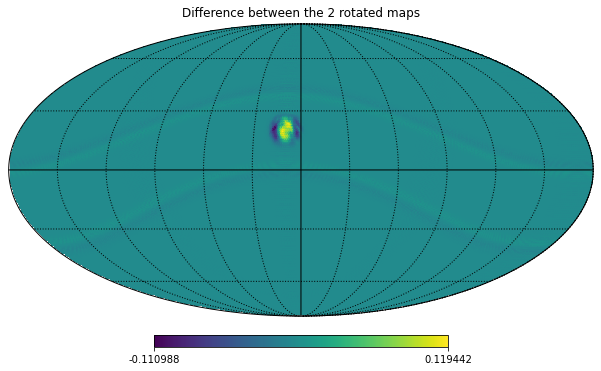

In [30]:
hp.mollview(m_smoothed_rotated_alms-m_smoothed_rotated_pixel, title="Difference between the 2 rotated maps")
hp.graticule();

In [31]:
rot_custom_back = hp.Rotator(rot=[longitude.to_value(u.deg), latitude.to_value(u.deg)])

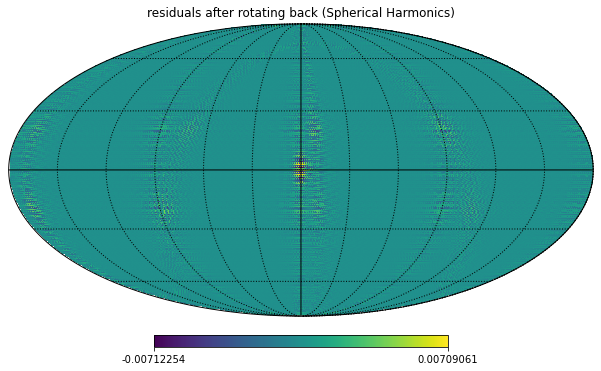

In [32]:
hp.mollview(m_smoothed-rot_custom_back.rotate_map_alms(m_smoothed_rotated_alms), title="residuals after rotating back (Spherical Harmonics)")
hp.graticule();

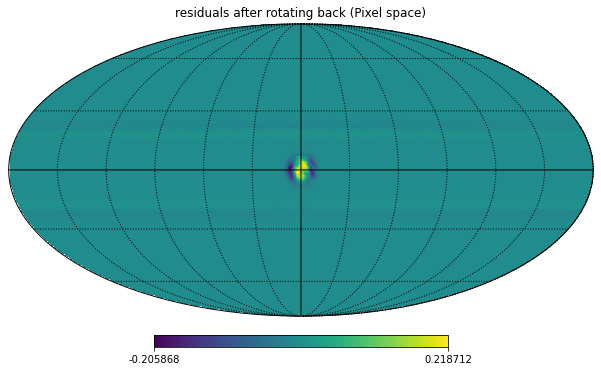

In [33]:
hp.mollview(m_smoothed-rot_custom_back.rotate_map_pixel(m_smoothed_rotated_pixel), title="residuals after rotating back (Pixel space)")
hp.graticule();

There is a huge difference between the methods, check the scales of the colorbars, this is made worse by the fact that we are using pixels that are quite big, it wouldn't be as bad with smaller pixels.